# Download and post-process MODIS LAI 

**MODIS product list**:

|Product|File name|Spatial resolution|Temporal resolution|Period|
|---|---|---|---|---|
|LAI|MCD15A3H.006_500m_aid0001.nc|500-m|4-day|2002-07-01 - present|
|Landcover|MCD12Q1.006_500m_aid0001.nc|500-m|yearly|2001-01-01 - present|
|ET|MOD16A2GF.006_500m_aid0001.nc|500-m|8-day|2000-01-01 - present|
|Snowcover|MOD10A2.006_500m_aid0001.nc|500-m|6-day?|2000-02-24 - present|

```{note}
To download using the script, make sure you have registered an Earthdata Login account at: https://urs.earthdata.nasa.gov/users/new.
```

In [1]:
import os
import cgi
import xarray as xr
import rioxarray
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

import h5py as h5

import geopandas as gpd
from shapely.geometry import mapping
import netCDF4 as nc
from datetime import datetime, timedelta
import requests

In [2]:
def get_bounds(fname_watershed_shp):
    """get the min,max bounds for lat,lon for a given watershed."""
    watershed_shape = gpd.read_file(fname_watershed_shp)

    bounds = watershed_shape.bounds
    # bounds

    lonl = watershed_shape.bounds['minx'].values[0]
    lonr = watershed_shape.bounds['maxx'].values[0]
    latb = watershed_shape.bounds['miny'].values[0]
    latt = watershed_shape.bounds['maxy'].values[0]    
    
    return lonl,lonr,latb,latt

In [3]:
def submit_request(fname_watershed_shp, task_name, product, layer, appeears_username, appeears_password, start_date="01-01-2000", end_date="12-31-2020"):
    """create a task for downloading MODIS data using AppEEARS.
    The step above can take some time (minutes to hours) depending upon the data volume. 
    Please wait until this step is completed!
    You can check the status of the job here: https://lpdaacsvc.cr.usgs.gov/appeears/explore
    """
    
    lonl,lonr,latb,latt = get_bounds(fname_watershed_shp)
    
    response = requests.post('https://lpdaacsvc.cr.usgs.gov/appeears/api/login', auth=(appeears_username, appeears_password))
    token_response = response.json()
    
    # creat task JSON file
    task = {
      "task_type": "area",
      "task_name": task_name,
      "params":
      {
        "dates": [
        {
          "startDate": start_date,
          "endDate": end_date
        }],
        "layers": [
        {
          "layer": layer,
          "product": product
        }],
        "output":
        {
          "format":
          {
            "type": "netcdf4"
          },
          "projection": "geographic"
        },
        "geo":
        {
          "type": "FeatureCollection",
          "fileName": "User-Drawn-Polygon",
          "features": [
          {
            "type": "Feature",
            "properties":
            {},
            "geometry":
            {
              "type": "Polygon",
              "coordinates": [
                [
                  [lonl, latb],
                  [lonl, latt],
                  [lonr, latt],
                  [lonr, latb],
                  [lonl, latb]
                ]
              ]
            }
          }]
        }
      }
    }    
    
    # submit the task request
    token = token_response['token']
    response = requests.post(
        'https://lpdaacsvc.cr.usgs.gov/appeears/api/task', 
        json=task, 
        headers={'Authorization': 'Bearer {0}'.format(token)})
    task_response = response.json()
    print(task_response)
    task_id = task_response['task_id']
    # print(task_id)    
    
    return task_id

In [4]:
def download_file(task_id, dest_dir):
    """Download file after the AppEEARS request is complete."""

    response = requests.get('https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}'.format(task_id))
    bundle_response = response.json()
    # print(bundle_response)

    test = bundle_response['files']
    test1 = test[0]
    file_id = test1['file_id']
    # print(file_id)

    # Save the LAI.nc dataset into a file
    # get a stream to the bundle file
    response = requests.get(
        'https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}/{1}'.format(task_id, file_id),
        stream=True)

    # parse the filename from the Content-Disposition header
    content_disposition = cgi.parse_header(response.headers['Content-Disposition'])[1]
    filename = os.path.basename(content_disposition['filename'])

    # create a destination directory to store the file in
    filepath = os.path.join(dest_dir, filename)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    # write the file to the destination directory
    with open(filepath, 'wb') as f:
        for data in response.iter_content(chunk_size=8192):
            f.write(data)  
    print(f"File is saved in {filepath}!")

In [5]:
start_date = "01-01-2000"
end_date = "12-31-2020"
name = 'NeversinkHeadwaters'
fname_watershed_shp = f'../data/shapefile/{name}.shp'

dest_dir = "../data/WW_output"
fname_lai = dest_dir + '/MCD15A3H.006_500m_aid0001.nc'
fname_lulc = dest_dir + '/MCD12Q1.006_500m_aid0001.nc'
fname_et = dest_dir + '/MOD16A2GF.006_500m_aid0001.nc'
fname_snowcover = dest_dir + '/MOD10A2.006_500m_aid0001.nc'

In [17]:
watershed_shape = gpd.read_file(fname_watershed_shp)
bounds = watershed_shape.bounds

# Import shapefile to provide the coordinates

In [14]:
lonl,lonr,latb,latt = get_bounds(fname_watershed_shp)

In [15]:
lonl,lonr,latb,latt

(-74.61365632247104, -74.35749518209956, 41.88587874311008, 42.035236269932035)

# Data download through USGS APPEEARS server

<font color='green'> Provide your NASA Earthdata username and password in the space below

In [ ]:
response = requests.post('https://lpdaacsvc.cr.usgs.gov/appeears/api/login', auth=('USERNAME', 'PASSWORD'))
token_response = response.json()
print(token_response)

## Download MODIS LAI

In [8]:
task = {
  "task_type": "area",
  "task_name": name + " LAI",
  "params":
  {
    "dates": [
    {
      "startDate": "07-01-2002",
      "endDate": "12-31-2020"
    }],
    "layers": [
    {
      "layer": "Lai_500m",
      "product": "MCD15A3H.006"
    }],
    "output":
    {
      "format":
      {
        "type": "netcdf4"
      },
      "projection": "geographic"
    },
    "geo":
    {
      "type": "FeatureCollection",
      "fileName": "User-Drawn-Polygon",
      "features": [
      {
        "type": "Feature",
        "properties":
        {},
        "geometry":
        {
          "type": "Polygon",
          "coordinates": [
            [
              [lonl, latb],
              [lonl, latt],
              [lonr, latt],
              [lonr, latb],
              [lonl, latb]
            ]
          ]
        }
      }]
    }
  }
}

In [9]:
# submit the task request
token = token_response['token']
response = requests.post(
    'https://lpdaacsvc.cr.usgs.gov/appeears/api/task', 
    json=task, 
    headers={'Authorization': 'Bearer {0}'.format(token)})
task_response = response.json()
print(task_response)
task_id = task_response['task_id']
print(task_id)

{'task_id': '1494e2d1-79eb-4450-8a2d-1671ed7563e2', 'status': 'pending'}
1494e2d1-79eb-4450-8a2d-1671ed7563e2


<font color='green'> The step above can take some time (minutes to hours) depending upon the data volume. Please wait until this step is completed. You can check the status of the job here: https://lpdaacsvc.cr.usgs.gov/appeears/explore

In [10]:
token = token_response['token']
response = requests.get('https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}'.format(task_id))
bundle_response = response.json()
print(bundle_response)

test = bundle_response['files']
test1 = test[0]

#test2 = test1['file_id']
file_id = test1['file_id']
print(file_id)

#Save the LAI.nc dataset into a file

# get a stream to the bundle file
#task_id = '7cbc128a-3f07-4630-835e-4a41e40c07d8'
#file_id = '209d887a-0ab9-465b-9634-58a610b99c09'
response = requests.get(
    'https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}/{1}'.format(task_id, file_id),
    stream=True)

# parse the filename from the Content-Disposition header
content_disposition = cgi.parse_header(response.headers['Content-Disposition'])[1]
filename = os.path.basename(content_disposition['filename'])

# create a destination directory to store the file in

filepath = os.path.join(dest_dir, filename)
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# write the file to the destination directory
with open(filepath, 'wb') as f:
    for data in response.iter_content(chunk_size=8192):
        f.write(data)

## Download MOIDS landcover

Landcover product from MODIS starts with `MCD12Q1.006`

In [14]:
##Download LULC data
task1 = {
  "task_type": "area",
  "task_name": name + " LULC",
  "params":
  {
    "dates": [
    {
      "startDate": "07-01-2002",
      "endDate": "12-31-2020"
    }],
    "layers": [
    {
      "layer": "LC_Type1",
      "product": "MCD12Q1.006"
    }],
    "output":
    {
      "format":
      {
        "type": "netcdf4"
      },
      "projection": "geographic"
    },
    "geo":
    {
      "type": "FeatureCollection",
      "fileName": "User-Drawn-Polygon",
      "features": [
      {
        "type": "Feature",
        "properties":
        {},
        "geometry":
        {
          "type": "Polygon",
          "coordinates": [
            [
              [lonl, latb],
              [lonl, latt],
              [lonr, latt],
              [lonr, latb],
              [lonl, latb]
            ]
          ]
        }
      }]
    }
  }
}

In [15]:
# submit the task request
token1 = token_response['token']
response1 = requests.post(
    'https://lpdaacsvc.cr.usgs.gov/appeears/api/task', 
    json=task1, 
    headers={'Authorization': 'Bearer {0}'.format(token)})
task_response1 = response1.json()
print(task_response1)
task_id1 = task_response1['task_id']
print(task_id1)

{'task_id': 'd28ac41b-34c8-40d1-99ec-184268f92d1f', 'status': 'pending'}
d28ac41b-34c8-40d1-99ec-184268f92d1f


<font color='green'> The step above can take some time (minutes to hours) depending upon the data volume. Please wait until this step is completed. You can check the status of the job here: https://lpdaacsvc.cr.usgs.gov/appeears/explore

In [18]:
token = token_response['token']
response1 = requests.get('https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}'.format(task_id1))
bundle_response1 = response1.json()
print(bundle_response1)

files1 = bundle_response1['files']
files2 = files1[0]

file_id1 = files2['file_id']
print(file_id1)

# get a stream to the bundle file
#task_id = '7cbc128a-3f07-4630-835e-4a41e40c07d8'
#file_id = '209d887a-0ab9-465b-9634-58a610b99c09'
response = requests.get(
    'https://lpdaacsvc.cr.usgs.gov/appeears/api/bundle/{0}/{1}'.format(task_id1, file_id1),
    stream=True)

# parse the filename from the Content-Disposition header
content_disposition = cgi.parse_header(response.headers['Content-Disposition'])[1]
filename = os.path.basename(content_disposition['filename'])

# create a destination directory to store the file in
# dest_dir = "../data-raw"
filepath = os.path.join(dest_dir, filename)
os.makedirs(os.path.dirname(filepath), exist_ok=True)

# write the file to the destination directory
with open(filepath, 'wb') as f:
    for data in response.iter_content(chunk_size=8192):
        f.write(data)

{'files': [{'sha256': '753a4e744ca04ff5a96bb2af8be320b4ec6571c28d01def3e6eab9dbb3a55872', 'file_id': '1cc69501-e598-4ae9-b2b0-3e2ba71f96db', 'file_name': 'MCD12Q1.006_500m_aid0001.nc', 'file_size': 28301, 'file_type': 'nc'}, {'sha256': 'd29d9a15144007340d7b2df860d3b1d9226f1eb645b2df3527b720722ceec1f4', 'file_id': '2ad122be-7db2-4aab-9f26-a43f59fd3578', 'file_name': 'MCD12Q1-006-QC-lookup.csv', 'file_size': 99, 'file_type': 'csv'}, {'sha256': '6d18320f61fde34173bd0f3c70aec92a6e30dca827e97b02fce706b5e0f3f8c9', 'file_id': 'd70aeae3-9cc2-430b-99c7-eab96e27a48b', 'file_name': 'MCD12Q1-006-QC-Statistics-QA.csv', 'file_size': 833, 'file_type': 'csv'}, {'sha256': '71bd0920bb638a75e7c80a1f1f12324f2d2f4666140c936d62425ec741605e19', 'file_id': 'c7054d71-6008-4461-8f4c-dbd782c532b4', 'file_name': 'MCD12Q1-006-LC-Type1-Statistics.csv', 'file_size': 1109, 'file_type': 'csv'}, {'sha256': 'dcb3d7f97d1d506e332bc7f8241ffe43cafc34bad5d0af30bd1ecd56812cdb8f', 'file_id': '96b32324-34d0-4db4-8839-1de9afcff4

## Download MOIDS ET


In [35]:
task_id = submit_request(fname_watershed_shp, task_name=name+ ' ET-test', product="MOD16A2GF.006", layer="ET_500m", 
                         appeears_username = 'USERNAME', appeears_password='PASSWORD')

{'task_id': 'be9b3775-d3d5-40d3-b15e-18123e127c5c', 'status': 'pending'}


In [40]:
download_file(task_id, dest_dir)

File is saved in ../data/WW_output/MOD16A2GF.006_500m_aid0001.nc!


## Download MOIDS snowcover


In [41]:
task_id = submit_request(fname_watershed_shp, task_name=name+ ' snowcover', product="MOD10A2.006", layer="Maximum_Snow_Extent", 
                         appeears_username = 'USERNAME', appeears_password='PASSWORD')

{'task_id': 'd0ec3b97-483a-4221-8ad0-cc2b7230fe5c', 'status': 'pending'}


In [94]:
download_file(task_id, dest_dir)

File is saved in ../data/WW_output/MOD10A2.006_500m_aid0001.nc!


# Use the downloaded LAI and LULC data

In [26]:
dset = xr.open_dataset(fname_lai)

dset

<xarray.Dataset>
Dimensions:       (lat: 37, lon: 63, time: 1698)
Coordinates:
  * time          (time) object 2002-07-04 00:00:00 ... 2020-12-30 00:00:00
  * lat           (lat) float64 42.04 42.03 42.03 42.02 ... 41.89 41.89 41.89
  * lon           (lon) float64 -74.61 -74.61 -74.61 ... -74.36 -74.36 -74.36
Data variables:
    crs           int8 ...
    Lai_500m      (time, lat, lon) float32 ...
    FparLai_QC    (time, lat, lon) float32 ...
    FparExtra_QC  (time, lat, lon) float32 ...
Attributes:
    title:        MCD15A3H.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.68
    references:   See README.md
    history:      See README.md

In [27]:
data = dset.Lai_500m
data.shape

(1698, 37, 63)

In [28]:
data.min(), data.max()

(<xarray.DataArray 'Lai_500m' ()>
 array(0., dtype=float32),
 <xarray.DataArray 'Lai_500m' ()>
 array(7., dtype=float32))

# Subset data

In [29]:
mask_data = data.where((data <= 10) & (data >= 0))

mask_data.min(), mask_data.max()

(<xarray.DataArray 'Lai_500m' ()>
 array(0., dtype=float32),
 <xarray.DataArray 'Lai_500m' ()>
 array(7., dtype=float32))

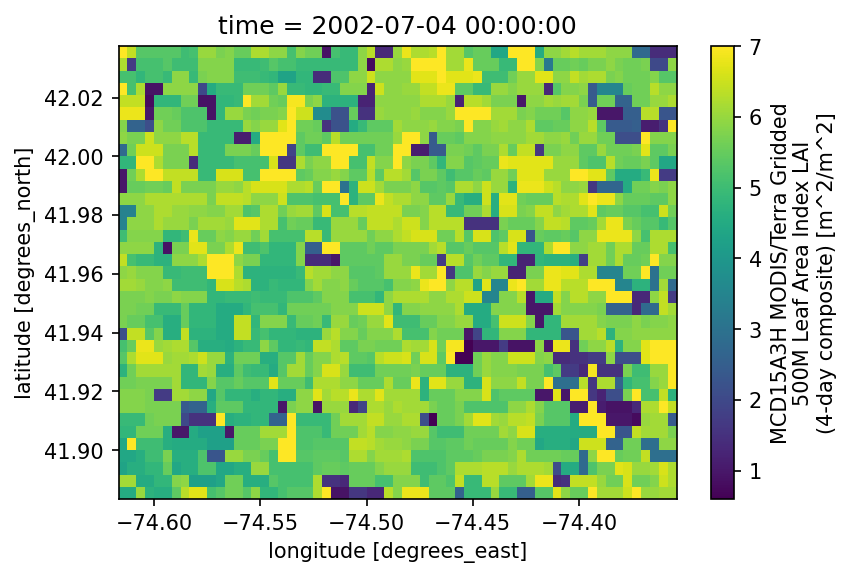

In [30]:
mask_data.isel(time = 0).plot()

In [31]:
mask_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mask_data.rio.write_crs("epsg:4326", inplace=True)
clipped_data = mask_data.rio.clip(watershed_shape.geometry.apply(mapping), watershed_shape.crs, drop = True)

In [32]:
LAI_data = clipped_data

(41.88587874311008, 42.035236269932035)

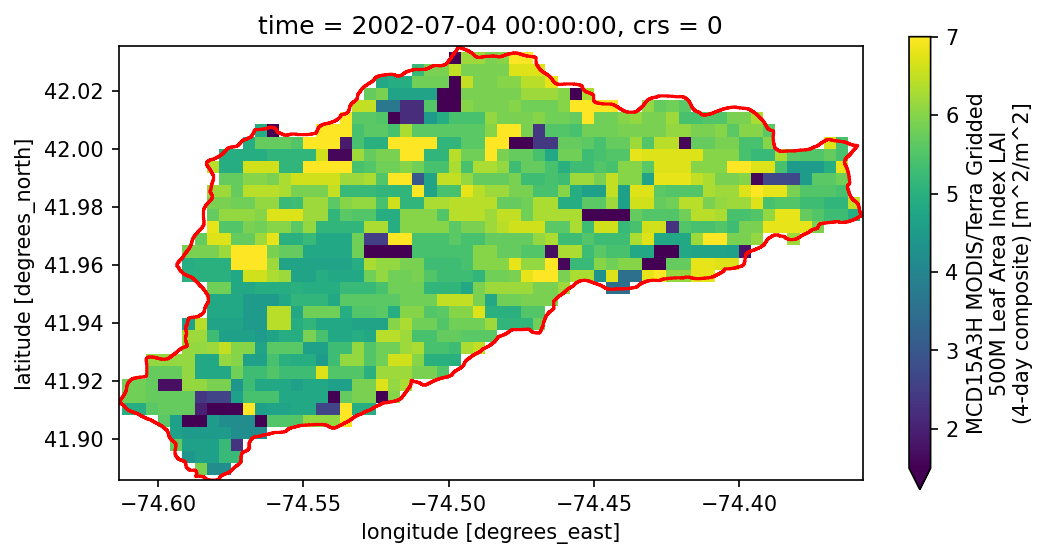

In [33]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
clipped_data.isel(time = 0).plot( robust = True, ax=ax)
watershed_shape.boundary.plot(ax=ax, color ='r')
ax.set_aspect('equal')
ax.set_xlim([bounds['minx'].values[0], bounds['maxx'].values[0]])
ax.set_ylim([bounds['miny'].values[0], bounds['maxy'].values[0]])

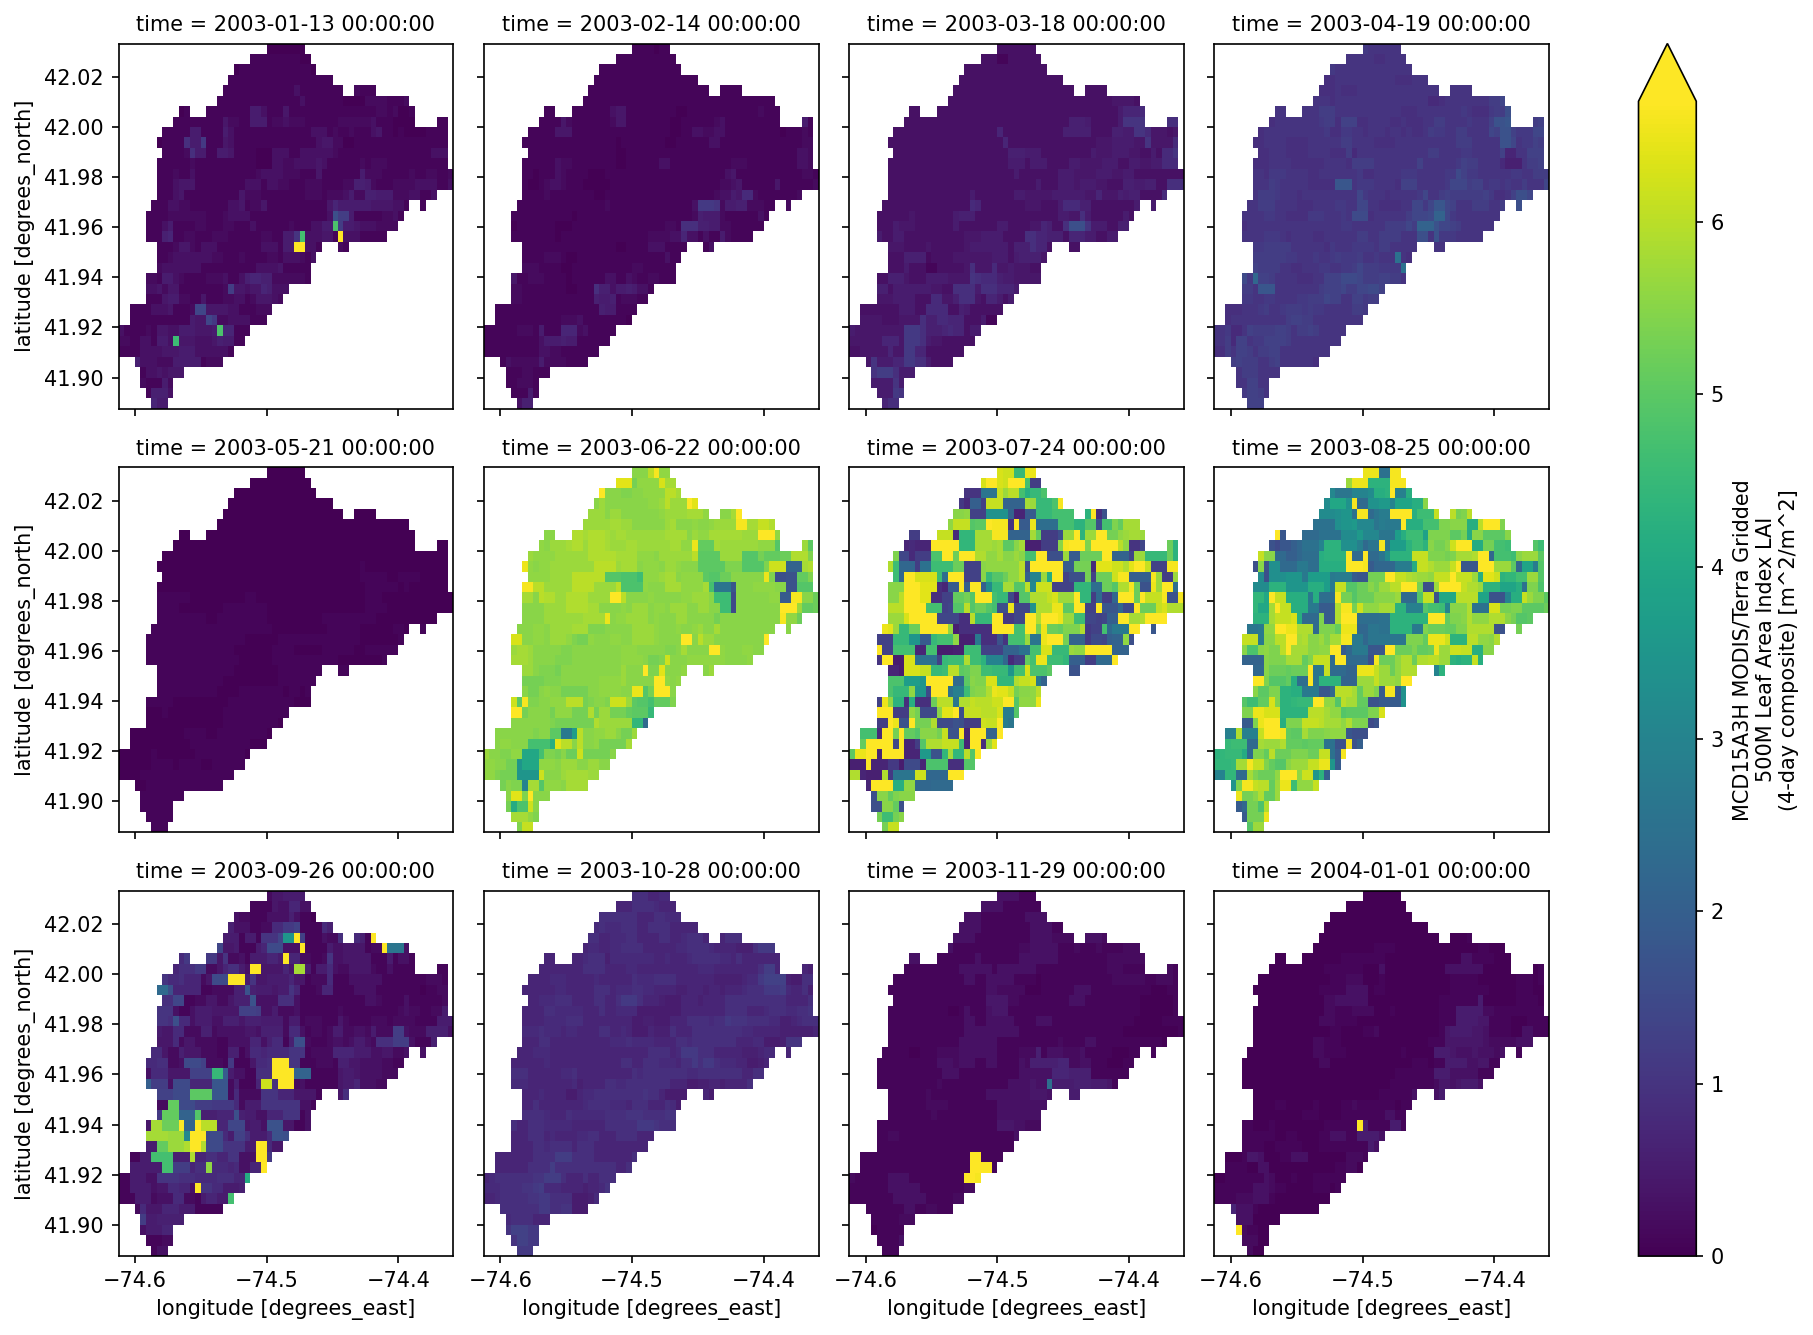

In [52]:
clipped_data.isel(time = slice(48, 137, 8)).plot(x="lon", y='lat', col="time", col_wrap=4, robust = True,
        cmap = 'viridis',)

# LULC data

In [6]:
dset = xr.open_dataset(fname_lulc)
dset

<xarray.Dataset>
Dimensions:   (lat: 37, lon: 63, time: 19)
Coordinates:
  * time      (time) object 2002-01-01 00:00:00 ... 2020-01-01 00:00:00
  * lat       (lat) float64 42.04 42.03 42.03 42.02 ... 41.9 41.89 41.89 41.89
  * lon       (lon) float64 -74.61 -74.61 -74.61 -74.6 ... -74.36 -74.36 -74.36
Data variables:
    crs       int8 ...
    LC_Type1  (time, lat, lon) float32 ...
    QC        (time, lat, lon) float32 ...
Attributes:
    title:        MCD12Q1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.68
    references:   See README.md
    history:      See README.md

In [7]:
data = dset.LC_Type1

data.shape

(19, 37, 63)

In [8]:
ids, counts = np.unique(data.values[~np.isnan(data.values)], return_counts=True)

ids, counts

(array([4., 5., 8.], dtype=float32), array([43635,   621,    33]))

In [9]:
#Colors are based on NLCD LULC colors
lc_type1_colors = {
        -1:  ('Unclassified', (0.00000000000,  0.00000000000,  0.00000000000)),
        0: ('Open Water', (0.27843137255,  0.41960784314,  0.62745098039)),
        1: ('Evergreen Needleleaf Forests', (0.10980392157,  0.38823529412,  0.18823529412)),
        2: ('Evergreen Broadleaf Forests', (0.10980392157,  0.38823529412,  0.18823529412)),
        3: ('Deciduous Needleleaf Forests', (0.40784313726,  0.66666666667,  0.38823529412)),
        4: ('Deciduous Broadleaf Forests', (0.40784313726,  0.66666666667,  0.38823529412)),
        5: ('Mixed Forests', (0.70980392157,  0.78823529412,  0.55686274510)),
        6: ('Closed Shrublands', (0.80000000000,  0.72941176471,  0.48627450980)),
        7: ('Open Shrublands', (0.80000000000,  0.72941176471,  0.48627450980)),
        # 8: ('Woody Savannas', (0.40784313726,  0.66666666667,  0.38823529412)),
        8: ('Woody Savannas', (0.60980392157,  0.68823529412,  0.55686274510)),
        9: ('Savannas', (0.70980392157,  0.78823529412,  0.55686274510)),
        10: ('Grasslands', (0.88627450980,  0.88627450980,  0.75686274510)),
        11: ('Permanent Wetlands', (0.43921568628,  0.63921568628,  0.72941176471)),
        12: ('Croplands', (0.66666666667,  0.43921568628,  0.15686274510)),
        13: ('Urban and Built up lands', (0.86666666667,  0.78823529412,  0.78823529412)),
        14: ('Cropland Natural Vegetation Mosaics', (0.66666666667,  0.43921568628,  0.15686274510)),
        15: ('Permanent Snow and Ice', (0.81960784314,  0.86666666667,  0.97647058824)),
        16: ('Barren Land', (0.69803921569,  0.67843137255,  0.63921568628)),
        17: ('Water Bodies', (0.27843137255,  0.41960784314,  0.62745098039)),
    } 


In [10]:
lc_colors = lc_type1_colors

In [11]:
colors = [lc_colors[i][1] for i in ids]

In [12]:
mask_data = data

In [18]:
mask_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mask_data.rio.write_crs("epsg:4326", inplace=True)
clipped_data = mask_data.rio.clip(watershed_shape.geometry.apply(mapping), watershed_shape.crs, drop = True)

In [19]:
landcover_data = clipped_data

In [20]:
ids, counts = np.unique(clipped_data.values[~np.isnan(clipped_data.values)], return_counts=True)
ids, counts

colors = [lc_colors[i][1] for i in ids]

labels = [lc_colors[i][0] for i in ids]

In [21]:
ids = [0] + ids.tolist() + [11]
colors = ['grey'] + colors + ['k']
labels = ['None'] + labels + ['']

([<matplotlib.axis.XTick at 0x1aa246970>,
 [Text(-1.0, 0, 'Unclassified'),
  Text(0.0, 0, 'Open Water'),
  Text(1.0, 0, 'Evergreen Needleleaf Forests'),
  Text(2.0, 0, 'Evergreen Broadleaf Forests'),
  Text(3.0, 0, 'Deciduous Needleleaf Forests'),
  Text(4.0, 0, 'Deciduous Broadleaf Forests'),
  Text(5.0, 0, 'Mixed Forests'),
  Text(6.0, 0, 'Closed Shrublands'),
  Text(7.0, 0, 'Open Shrublands'),
  Text(8.0, 0, 'Woody Savannas'),
  Text(9.0, 0, 'Savannas'),
  Text(10.0, 0, 'Grasslands'),
  Text(11.0, 0, 'Permanent Wetlands'),
  Text(12.0, 0, 'Croplands'),
  Text(13.0, 0, 'Urban and Built up lands'),
  Text(14.0, 0, 'Cropland Natural Vegetation Mosaics'),
  Text(15.0, 0, 'Permanent Snow and Ice'),
  Text(16.0, 0, 'Barren Land'),
  Text(17.0, 0, 'Water Bodies')])

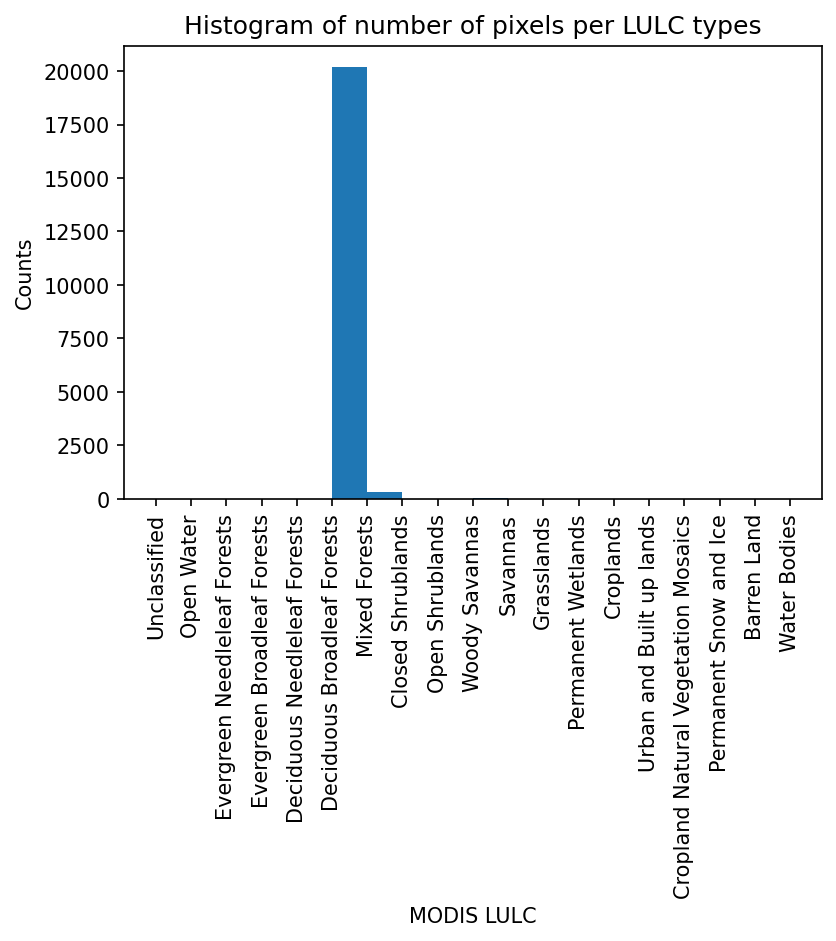

In [22]:
labelsp1 = [lc_colors[i][0] for i in lc_colors]

counts, bins = np.histogram(clipped_data, range=[-1,17], bins=18)
plt.hist(bins[:-1], bins=18, range=[-1,17], weights=counts)
plt.xlabel("MODIS LULC")
plt.ylabel("Counts")
plt.title("Histogram of number of pixels per LULC types")
plt.xticks(bins,labelsp1,rotation=90)

(41.88587874311008, 42.035236269932035)

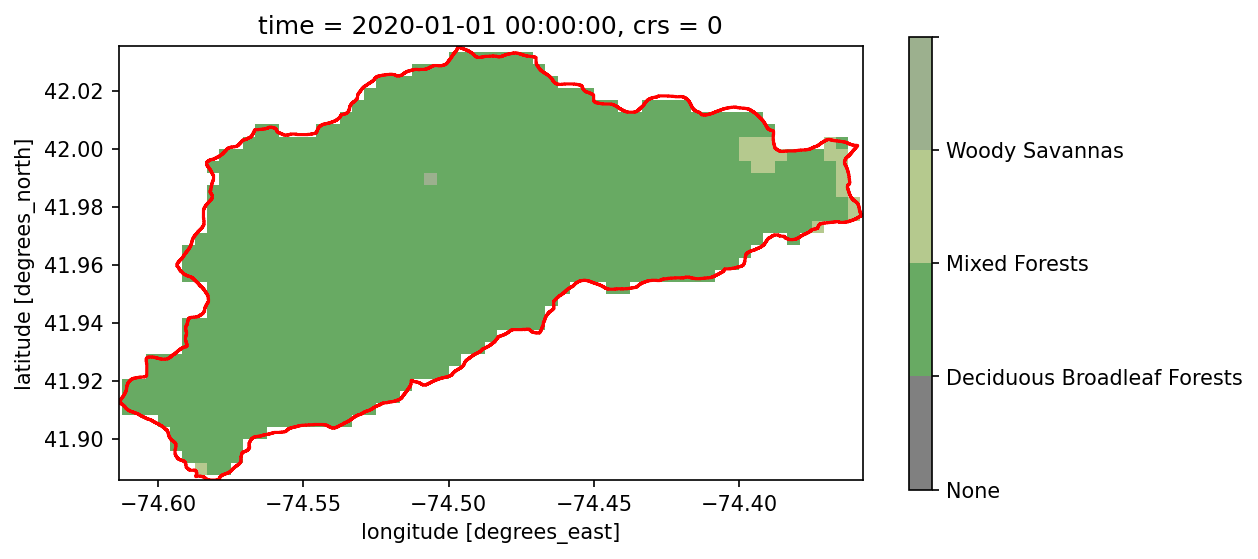

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
g = clipped_data.isel(time = -1).plot(  levels=ids, colors = colors, ax=ax, add_colorbar = False)
cb = plt.colorbar(g)
# cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(labels)

watershed_shape.boundary.plot(ax=ax, color ='r')
ax.set_aspect('equal')
ax.set_xlim([bounds['minx'].values[0], bounds['maxx'].values[0]])
ax.set_ylim([bounds['miny'].values[0], bounds['maxy'].values[0]])

In [34]:
ilandcover = landcover_data.sel(time= "2018-01-01").values[0,:,:]

# ilandcover.shape
lc_ids = np.unique(landcover_data.values[~np.isnan(landcover_data.values)])
lc_labels = [lc_colors[i][0] for i in lc_ids]
times = LAI_data.time.values

In [35]:
LAI_lc = []

for itime in times:
#     itime = times[0]
    iCC_LAI = LAI_data.sel(time= itime).values

    iLAI_lc = []
    for i,ilabel in zip(lc_ids, lc_labels):
        idx = np.where(ilandcover == i)
        coords = list(zip(idx[0], idx[1]))
        # choose mean of the LAI for each landcover type
        iLAI = np.nanmean(np.array([iCC_LAI[i] for i in coords]))

        iLAI_lc.append(iLAI)
    
    LAI_lc.append(iLAI_lc)

In [36]:
LAI_df = pd.DataFrame(LAI_lc, columns= lc_labels)
LAI_df['datetime'] = LAI_data.indexes['time'].to_datetimeindex()
LAI_df.set_index('datetime', inplace=True)

<ipython-input-36-afca7925ce50>:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  LAI_df['datetime'] = LAI_data.indexes['time'].to_datetimeindex()


(16801.0, 17897.0)

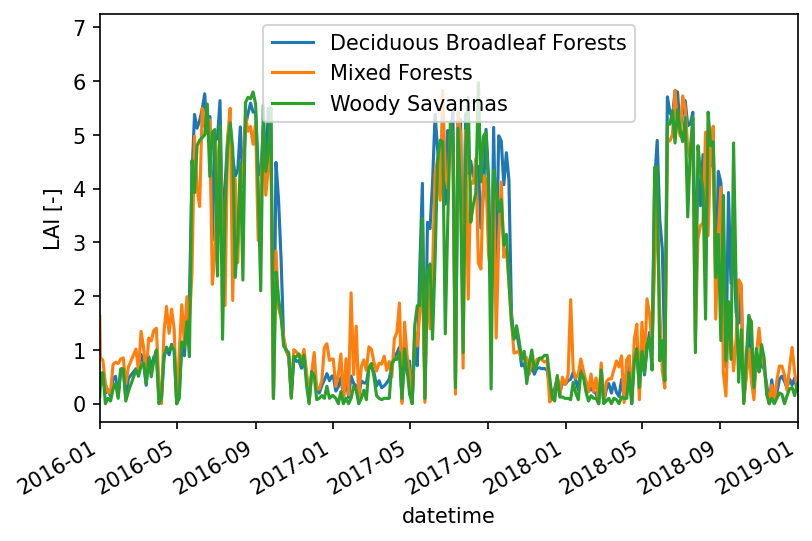

In [37]:
LAI_df.plot()
plt.ylabel('LAI [-]')
plt.xlim(["2016-01-01", "2019-01-01"])

In [38]:
LAI_df.to_csv(dest_dir + f"{name}_MODIS_LAI_df-raw.csv")

## save to HDF5

In [51]:
nlcd_LAI['time [s]'] = (nlcd_LAI.index - nlcd_LAI.index[0]).total_seconds()

In [ ]:
with h5.File(dest_dir + f'{name}_MODIS_LAI_072002_122020.h5', 'w') as fout:

    for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]']:
        fout.create_dataset(i, data= nlcd_LAI[i].values)

# Select dominant LULC types and use their LAI values for ATS run

In [92]:
ids, counts = np.unique(landcover_data.values[~np.isnan(landcover_data.values)], return_counts=True)

sum1 = sum(counts)
cutoff = sum1*0.05 #Separate LULC types with 5% of the pixel coverage cutoff
cutoff

1026.0

In [93]:
counts

array([20183,   304,    33])

In [39]:
ids1 = np.delete(ids, np.argwhere(counts < int(cutoff)))
print(ids1)

[4.]


In [40]:
colors1 = [lc_colors[i][1] for i in ids1]
labels1 = [lc_colors[i][0] for i in ids1]

In [41]:
labels1

['Deciduous Broadleaf Forests']

In [42]:
ids1, counts = np.unique(ids1, return_counts=True)

In [43]:
countLULCclass = sum(counts)
countLULCclass

1

In [44]:
ids, counts = np.unique(CC_landcover.values[~np.isnan(CC_landcover.values)], return_counts=True)

if(countLULCclass > 5):
    dom = np.argpartition(-counts, range(5))[:5]
    print(ids[dom])  # prints the 5 most frequent LULC IDs
elif(countLULCclass < 5 and countLULCclass > 3):
    dom = np.argpartition(-counts, range(3))[:3] 
    print(ids[dom])  # prints the 3 most frequent LULC IDs
elif(countLULCclass < 3 and countLULCclass > 1):
    dom = np.argpartition(-counts, range(2))[:2]
    print(ids[dom])  # prints the 2 most frequent LULC IDs
else:
    dom = np.argpartition(-counts, range(1))[:1]
    print(ids[dom])  # prints the most frequent LULC ID


[4.]


In [45]:
if(countLULCclass > 5):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC3 = a[2]
    LULC4 = a[3]
    LULC5 = a[4]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
    LULC3label = lc_colors[LULC3][0]
    LULC4label = lc_colors[LULC4][0]
    LULC5label = lc_colors[LULC5][0]
elif(countLULCclass < 5 and countLULCclass > 3):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC3 = a[2]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
    LULC3label = lc_colors[LULC3][0]
elif(countLULCclass < 3 and countLULCclass > 1):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
else:
    a = ids[dom]
    LULC1 = a[0]
    LULC1label = lc_colors[LULC1][0]

# MODIS and NLCD crosswalk

<font color='green'> Users may change the crosswalk between MODIS and NLCD labels based on their study area characterisctics

In [46]:
#Colors are based on NLCD LULC colors
MODIS_labels = ['Unclassified', 
                'Open Water', 
                'Evergreen Needleleaf Forests', 
                'Evergreen Broadleaf Forests',
                'Deciduous Needleleaf Forests', 
                'Deciduous Broadleaf Forests', 
                'Mixed Forests', 
                'Closed Shrublands', 
                'Open Shrublands', 
                'Woody Savannas', 
                'Savannas', 
                'Grasslands', 
                'Permanent Wetlands', 
                'Croplands', 
                'Urban and Built up lands', 
                'Cropland Natural Vegetation Mosaics', 
                'Permanent Snow and Ice', 
                'Barren Land', 
                'Water Bodies']

In [47]:
NLCD_labels = ['None',
               'Open Water',
               'Evergreen Forest',
               'Evergreen Forest',
               'Deciduous Forest',
               'Deciduous Forest',
               'Mixed Forest',
               'Shrub/Scrub',
               'Shrub/Scrub',
               'Woody Wetlands',
               'Pasture/Hay',
               'Grassland/Herbaceous',
               'Emergent Herbaceous Wetlands',
               'Cultivated Crops',
               'Developed, Medium Intensity',
               'Cultivated Crops',
               'Perrenial Ice/Snow',
               'Barren Land',
               'Open Water']

In [48]:
compare_labels = pd.DataFrame({'MODIS_labels': MODIS_labels, 'NLCD_labels': NLCD_labels})
compare_labels

,MODIS_labels,NLCD_labels
0,Unclassified,None
1,Open Water,Open Water
2,Evergreen Needleleaf Forests,Evergreen Forest
3,Evergreen Broadleaf Forests,Evergreen Forest
4,Deciduous Needleleaf Forests,Deciduous Forest
5,Deciduous Broadleaf Forests,Deciduous Forest
6,Mixed Forests,Mixed Forest
7,Closed Shrublands,Shrub/Scrub
8,Open Shrublands,Shrub/Scrub
9,Woody Savannas,Woody Wetlands


In [49]:
NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
NLCDLULC1label1

'Deciduous Forest'

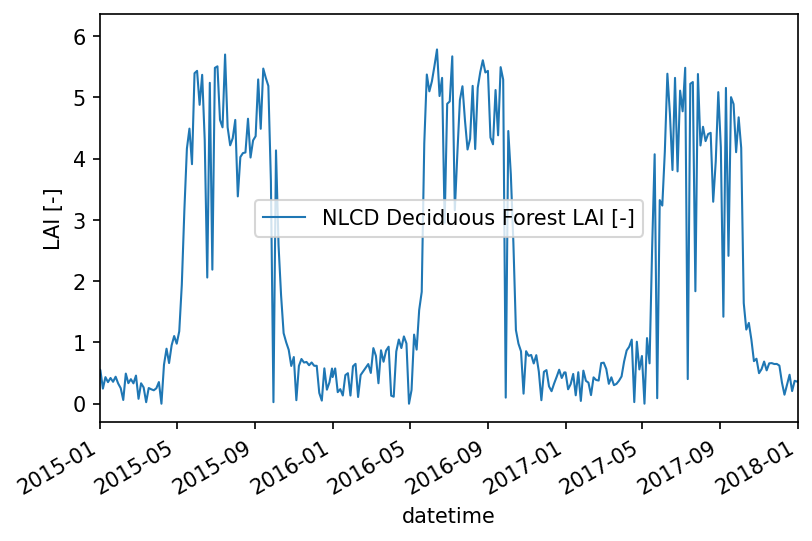

In [50]:
nlcd_LAI = LAI_df.copy()

if(countLULCclass > 5):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    NLCDLULC3label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC3label1 = NLCDLULC3label['NLCD_labels'].values[0]
    NLCDLULC4label=compare_labels[compare_labels['MODIS_labels']==LULC3label]
    NLCDLULC4label1 = NLCDLULC4label['NLCD_labels'].values[0]
    NLCDLULC5label=compare_labels[compare_labels['MODIS_labels']==LULC4label]
    NLCDLULC5label1 = NLCDLULC5label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[{LULC1label}]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[{LULC2label}]
    nlcd_LAI[f'NLCD {NLCDLULC3label1} LAI [-]'] = LAI_df[{LULC3label}]
    nlcd_LAI[f'NLCD {NLCDLULC4label1} LAI [-]'] = LAI_df[{LULC4label}]
    nlcd_LAI[f'NLCD {NLCDLULC5label1} LAI [-]'] = LAI_df[{LULC5label}]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]', f'NLCD {NLCDLULC5label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2015,1,1), datetime(2018,1,1))

elif(countLULCclass < 5 and countLULCclass > 3):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    NLCDLULC3label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC3label1 = NLCDLULC3label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[{LULC1label}]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[{LULC2label}]
    nlcd_LAI[f'NLCD {NLCDLULC3label1} LAI [-]'] = LAI_df[{LULC3label}]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2015,1,1), datetime(2018,1,1))
    
elif(countLULCclass < 3 and countLULCclass > 1):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[{LULC1label}]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[{LULC2label}]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2015,1,1), datetime(2018,1,1))
    
else:
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[{LULC1label}]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2015,1,1), datetime(2018,1,1))

In [51]:
nlcd_LAI['time [s]'] = (nlcd_LAI.index - nlcd_LAI.index[0]).total_seconds()

<font color='green'> If any of the NLCD LULC types (for cropland, evergreen, deciduous or shrub) present twice in the dominant MODIS LULC category, remove one of them before the h5 file generation, otherwise similar name conflict would be present.

In [53]:
if(countLULCclass > 5):
    with h5.File(f'../data-raw/{name}_MODIS_LAI_072002_122020.h5', 'w') as fout:
   
        for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]', f'NLCD {NLCDLULC5label1} LAI [-]']:
            fout.create_dataset(i, data= nlcd_LAI[i].values)
elif(countLULCclass < 5 and countLULCclass > 3):
    with h5.File(f'../data-raw/{name}_MODIS_LAI_072002_122020.h5', 'w') as fout:
   
        for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]']:
            fout.create_dataset(i, data= nlcd_LAI[i].values)
elif(countLULCclass < 3 and countLULCclass > 1):
    with h5.File(f'../data-raw/{name}_MODIS_LAI_072002_122020.h5', 'w') as fout:
   
        for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]']:
            fout.create_dataset(i, data= nlcd_LAI[i].values)
else:
    with h5.File(f'../data-raw/{name}_MODIS_LAI_072002_122020.h5', 'w') as fout:
   
        for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]']:
            fout.create_dataset(i, data= nlcd_LAI[i].values)